In [2]:
# datasets/prepare_data.py

import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
from typing import Tuple, List

# MNIST transforms
""" MNIST_transform_train = transforms.Compose(
    [
        transforms.RandomCrop(28, padding=4),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
) """

MNIST_transform_train = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

MNIST_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

# CIFAR-10 transforms
cifar10_transform_train = transforms.Compose(
    [
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

cifar10_transform_test = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)


def get_dataloaders(
    n: int, dataset_name: str, batch_size: int, repeat: int = 1
) -> Tuple[List[torch.utils.data.DataLoader], torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    generator = torch.Generator()
    generator.manual_seed(seed)

    if dataset_name == "CIFAR10":
        transform_train, transform_test = (
            cifar10_transform_train,
            cifar10_transform_test,
        )
        trainset = torchvision.datasets.CIFAR10(
            root="/root/GanLuo/ICML2025_project/data/raw/CIFAR10",
            train=True,
            download=False,
            transform=transform_train,
        )
        testset = torchvision.datasets.CIFAR10(
            root="/root/GanLuo/ICML2025_project/data/raw/CIFAR10",
            train=False,
            download=False,
            transform=transform_test,
        )
    elif dataset_name == "MNIST":
        transform_train, transform_test = MNIST_transform_train, MNIST_transform_test
        trainset = torchvision.datasets.MNIST(
            root="/home/lg/ICML2025_project/data/raw/MNIST",
            train=True,
            download=False,
            transform=transform_train,
        )
        testset = torchvision.datasets.MNIST(
            root="/home/lg/ICML2025_project/data/raw/MNIST",
            train=False,
            download=False,
            transform=transform_test,
        )
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    # Save the original trainset for full_trainloader
    original_trainset = trainset

    # Repeat the training dataset if repeat > 1
    if repeat > 1:
        trainset = torch.utils.data.ConcatDataset([trainset] * repeat)

    total_train_size = len(trainset)
    subset_sizes = [
        total_train_size // n + (1 if i < total_train_size % n else 0) for i in range(n)
    ]

    subsets = torch.utils.data.random_split(trainset, subset_sizes, generator=generator)

    trainloader_list = [
        torch.utils.data.DataLoader(
            subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            prefetch_factor=2,
            persistent_workers=True,
            generator=generator,
        )
        for subset in subsets
    ]

    # Create a DataLoader for the full training set using the original trainset
    full_trainloader = torch.utils.data.DataLoader(
        original_trainset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True,
        generator=generator,
    )

    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=100,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        prefetch_factor=2,
        persistent_workers=True,
        generator=generator,
    )

    return trainloader_list, testloader, full_trainloader


# def get_dataloaders_high_hetero(
#     n: int, dataset_name: str, batch_size: int, repeat: int = 1
# ) -> Tuple[List[torch.utils.data.DataLoader], torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
#     seed = 42
#     torch.manual_seed(seed)
#     np.random.seed(seed)
#     random.seed(seed)

#     generator = torch.Generator()
#     generator.manual_seed(seed)

#     # Load dataset
#     if dataset_name == "CIFAR10":
#         transform_train, transform_test = (
#             cifar10_transform_train,
#             cifar10_transform_test,
#         )
#         trainset = torchvision.datasets.CIFAR10(
#             root="/root/GanLuo/ICML2025_project/data/raw/CIFAR10",
#             train=True,
#             download=False,
#             transform=transform_train,
#         )
#         testset = torchvision.datasets.CIFAR10(
#             root="/root/GanLuo/ICML2025_project/data/raw/CIFAR10",
#             train=False,
#             download=False,
#             transform=transform_test,
#         )
#         num_classes = 10
#     elif dataset_name == "MNIST":
#         transform_train, transform_test = MNIST_transform_train, MNIST_transform_test
#         trainset = torchvision.datasets.MNIST(
#             root="/Users/luogan/Code/ICML2025_project/data/raw/MNIST",
#             train=True,
#             download=False,
#             transform=transform_train,
#         )
#         testset = torchvision.datasets.MNIST(
#             root="/Users/luogan/Code/ICML2025_project/data/raw/MNIST",
#             train=False,
#             download=False,
#             transform=transform_test,
#         )
#         num_classes = 10
#     else:
#         raise ValueError(f"Unsupported dataset: {dataset_name}")

#     # Save original trainset for full_trainloader
#     original_trainset = trainset

#     # Repeat the training dataset if repeat > 1
#     if repeat > 1:
#         trainset = torch.utils.data.ConcatDataset([trainset] * repeat)

#     # Get labels and create class-specific indices
#     labels = np.array(trainset.targets)
#     class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

#     # Create heterogeneous distributions for each node
#     subsets = []
#     total_size = len(trainset)
#     base_size = total_size // n
    
#     # Generate Dirichlet distribution for class proportions across nodes
#     alpha = 0.5  # Lower alpha means higher heterogeneity
#     class_dist = np.random.dirichlet([alpha] * n, num_classes)
    
#     # Assign samples to each node
#     for node in range(n):
#         node_indices = []
#         node_size = base_size + (1 if node < total_size % n else 0)
        
#         # Calculate target number of samples per class for this node
#         target_dist = class_dist[:, node] * node_size
        
#         for cls in range(num_classes):
#             num_samples = int(target_dist[cls])
#             available_indices = class_indices[cls]
            
#             if len(available_indices) > 0:
#                 selected = np.random.choice(
#                     available_indices,
#                     size=min(num_samples, len(available_indices)),
#                     replace=False
#                 )
#                 node_indices.extend(selected)
#                 # Remove used indices
#                 class_indices[cls] = np.setdiff1d(class_indices[cls], selected)
                
#         subsets.append(torch.utils.data.Subset(trainset, node_indices))

#     # Create DataLoaders for each subset
#     trainloader_list = [
#         torch.utils.data.DataLoader(
#             subset,
#             batch_size=batch_size,
#             shuffle=True,
#             num_workers=4,
#             pin_memory=True,
#             prefetch_factor=2,
#             persistent_workers=True,
#             generator=generator,
#         )
#         for subset in subsets
#     ]

#     # Full training set DataLoader
#     full_trainloader = torch.utils.data.DataLoader(
#         original_trainset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=4,
#         pin_memory=True,
#         prefetch_factor=2,
#         persistent_workers=True,
#         generator=generator,
#     )

#     # Test set DataLoader
#     testloader = torch.utils.data.DataLoader(
#         testset,
#         batch_size=100,
#         shuffle=False,
#         num_workers=4,
#         pin_memory=True,
#         prefetch_factor=2,
#         persistent_workers=True,
#         generator=generator,
#     )

#     return trainloader_list, testloader, full_trainloader



import seaborn as sns
import matplotlib.pyplot as plt

def visualize_heatmap(trainloader_list, num_classes=10):
    num_nodes = len(trainloader_list)
    class_counts = np.zeros((num_nodes, num_classes))

    # 统计类别分布
    for node_idx, loader in enumerate(trainloader_list):
        for _, labels in loader:
            for cls in range(num_classes):
                class_counts[node_idx, cls] += (labels == cls).sum().item()

    # 绘制热力图
    plt.figure(figsize=(8, 6))
    sns.heatmap(class_counts, annot=True, fmt='.0f', cmap='YlOrRd')
    plt.xlabel('type')
    plt.ylabel('node')
    plt.title('heatmap of class distribution')
    plt.show()

# 调用示例
# visualize_heatmap(trainloader_list)

from scipy.stats import entropy

def visualize_kl_divergence(trainloader_list, num_classes=10):
    num_nodes = len(trainloader_list)
    class_counts = np.zeros((num_nodes, num_classes))

    # 统计类别分布
    for node_idx, loader in enumerate(trainloader_list):
        for _, labels in loader:
            for cls in range(num_classes):
                class_counts[node_idx, cls] += (labels == cls).sum().item()

    # 计算比例
    class_ratios = class_counts / class_counts.sum(axis=1, keepdims=True)
    mean_dist = class_ratios.mean(axis=0)  # 平均分布

    # 计算KL散度
    kl_divs = [entropy(class_ratios[i], mean_dist) for i in range(num_nodes)]

    # 绘制
    plt.bar(range(num_nodes), kl_divs)
    plt.xticks(range(num_nodes), [f'node {i+1}' for i in range(num_nodes)])
    plt.ylabel('KL divergence')
    plt.xlabel('node')
    plt.title('KL divergence of class distribution')
    plt.show()

# 调用示例
# visualize_kl_divergence(trainloader_list)

In [4]:
n = 16
dataset_name = "MNIST"
batch_size = 128
repeat = 1

trainloader_list, testloader, full_trainloader = get_dataloaders(n, dataset_name, batch_size, repeat)

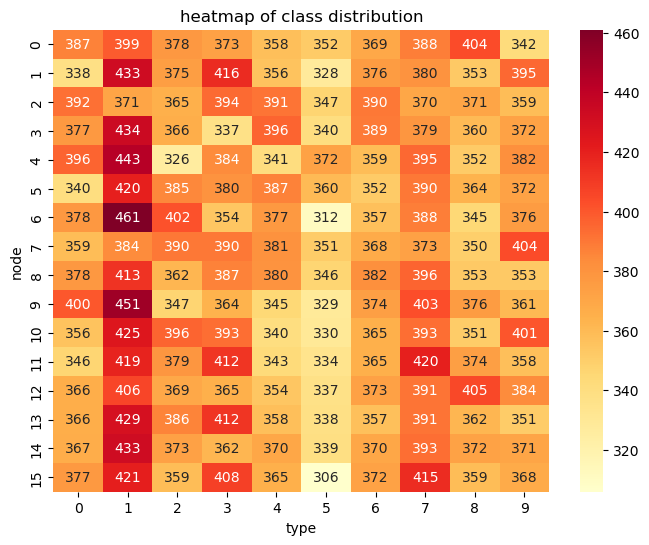

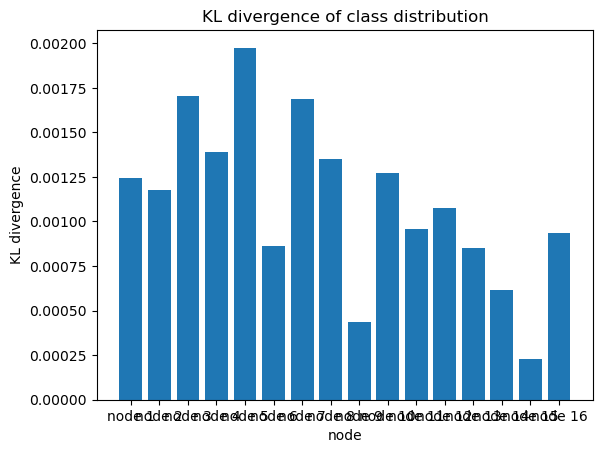

In [5]:
visualize_hmap(trainloader_list)
visualize_kl_divergence(trainloader_list)

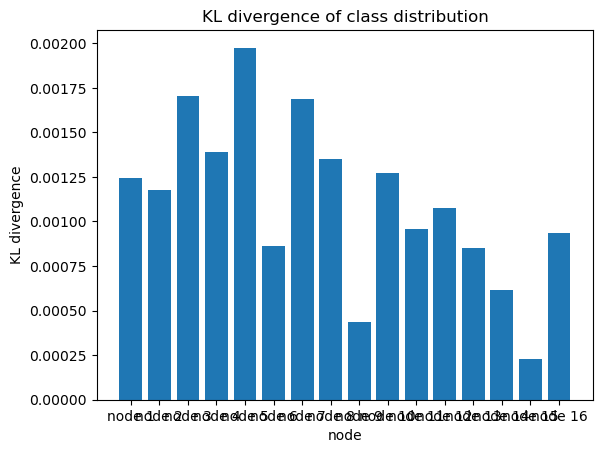

In [6]:
visualize_kl_divergence(trainloader_list)

In [9]:
n = 16
dataset_name = "MNIST"
batch_size = 128
repeat = 1

trainloader_list, testloader, full_trainloader = get_dataloaders_high_hetero(n, dataset_name, batch_size, repeat)

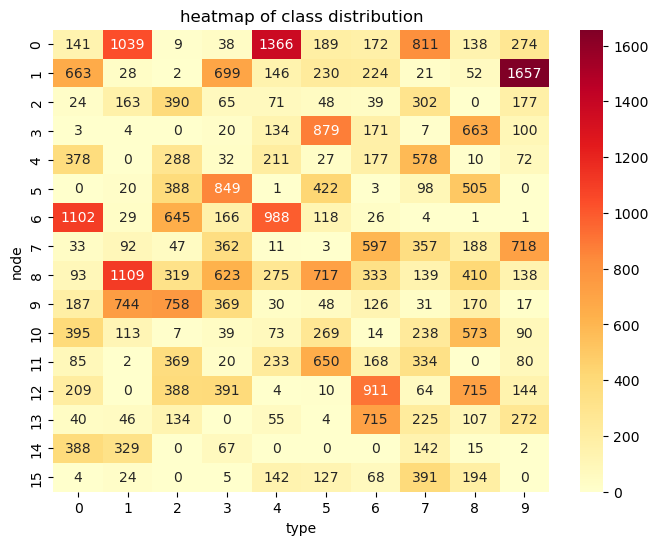

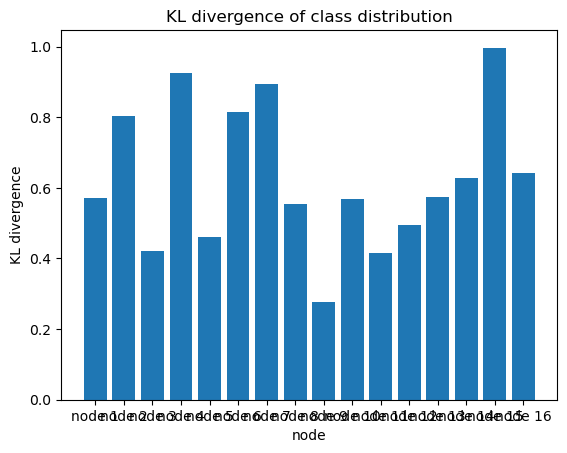

In [10]:
visualize_heatmap(trainloader_list)
visualize_kl_divergence(trainloader_list)

In [18]:
import torch
import torchvision
import numpy as np
import random
from typing import List, Tuple

# Assume necessary transforms are defined elsewhere:
# cifar10_transform_train, cifar10_transform_test
# MNIST_transform_train, MNIST_transform_test
# Example dummy transforms if not defined:
from torchvision import transforms
cifar10_transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
cifar10_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
MNIST_transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
MNIST_transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# --- End Example Transforms ---


def get_dataloaders_hetero_balanced(
    n: int,
    dataset_name: str,
    batch_size: int,
    alpha: float = 1e7,  # Dirichlet parameter, lower means higher heterogeneity
    repeat: int = 1,
    seed: int = 42,
) -> Tuple[List[torch.utils.data.DataLoader], torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """
    Generates DataLoaders with heterogeneous data distribution across nodes,
    while ensuring each node has approximately the same total number of samples.

    Args:
        n (int): Number of client nodes.
        dataset_name (str): Name of the dataset ('CIFAR10' or 'MNIST').
        batch_size (int): Batch size for the DataLoaders.
        alpha (float): Parameter for the Dirichlet distribution controlling heterogeneity.
                       Lower values lead to higher heterogeneity. Defaults to 0.5.
        repeat (int): How many times to repeat the training dataset before splitting.
                      Useful for ensuring enough samples when n is large. Defaults to 1.
        seed (int): Random seed for reproducibility. Defaults to 42.

    Returns:
        Tuple[List[torch.utils.data.DataLoader], torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
            - List of training DataLoaders (one for each node).
            - Test DataLoader.
            - Full training set DataLoader (using the original non-repeated trainset).
    """
    # Set seeds for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    generator = torch.Generator()
    generator.manual_seed(seed)

    # Load dataset
    if dataset_name == "CIFAR10":
        transform_train, transform_test = (
            cifar10_transform_train,
            cifar10_transform_test,
        )
        # Adjust paths as needed
        root_dir = "/root/GanLuo/ICML2025_project/data/raw/CIFAR10"
        try:
            trainset = torchvision.datasets.CIFAR10(
                root=root_dir, train=True, download=False, transform=transform_train
            )
            testset = torchvision.datasets.CIFAR10(
                root=root_dir, train=False, download=False, transform=transform_test
            )
        except Exception as e:
            print(f"Could not load CIFAR10 from {root_dir}. Trying with download=True. Error: {e}")
            trainset = torchvision.datasets.CIFAR10(
                root="./data/CIFAR10", train=True, download=True, transform=transform_train
            )
            testset = torchvision.datasets.CIFAR10(
                root="./data/CIFAR10", train=False, download=True, transform=transform_test
            )
        num_classes = 10
    elif dataset_name == "MNIST":
        transform_train, transform_test = MNIST_transform_train, MNIST_transform_test
        # Adjust paths as needed
        root_dir = "/home/lg/ICML2025_project/data/raw/MNIST"
        try:
            trainset = torchvision.datasets.MNIST(
                root=root_dir, train=True, download=False, transform=transform_train
            )
            testset = torchvision.datasets.MNIST(
                root=root_dir, train=False, download=False, transform=transform_test
            )
        except Exception as e:
            print(f"Could not load MNIST from {root_dir}. Trying with download=True. Error: {e}")
            trainset = torchvision.datasets.MNIST(
                root="./data/MNIST", train=True, download=True, transform=transform_train
            )
            testset = torchvision.datasets.MNIST(
                root="./data/MNIST", train=False, download=True, transform=transform_test
            )
        num_classes = 10
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    # Save original trainset for full_trainloader before potential repeat
    original_trainset = trainset

    # Repeat the training dataset if repeat > 1
    if repeat > 1:
        trainset = torch.utils.data.ConcatDataset([trainset] * repeat)

    # Get labels
    if isinstance(trainset, torch.utils.data.ConcatDataset):
        labels = np.concatenate([np.array(d.targets) for d in trainset.datasets])
    else:
        labels = np.array(trainset.targets)

    total_size = len(labels)

    # Get class indices (list of arrays, one for each class)
    class_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    # --- Allocation Strategy ---
    # Use Dirichlet distribution to determine the proportion of *each class*
    # that should go to *each node*.
    # Shape: (num_classes, n)
    class_dist_proportions = np.random.dirichlet([alpha] * n, num_classes)

    # Initialize list to store indices for each node
    node_indices = [[] for _ in range(n)]

    # Distribute samples class by class
    for c in range(num_classes):
        indices_c = class_indices[c]
        num_samples_c = len(indices_c)

        # Ensure proportions sum to 1 for safety (should be close already)
        proportions_c = class_dist_proportions[c, :]
        proportions_c /= proportions_c.sum()

        # Use multinomial distribution to assign samples of this class to nodes
        # This ensures all samples of the class are assigned, and respects the proportions
        try:
            samples_per_node_c = np.random.multinomial(num_samples_c, proportions_c)
        except ValueError as e:
            # Handle potential floating point inaccuracies in proportions_c summing slightly off 1.0
            # print(f"Warning: Adjusting proportions for class {c} due to sum {proportions_c.sum()}. Error: {e}")
            proportions_c = np.maximum(0, proportions_c) # Ensure non-negative
            proportions_c /= proportions_c.sum() # Renormalize
            samples_per_node_c = np.random.multinomial(num_samples_c, proportions_c)


        # Shuffle indices for this class to ensure random assignment within class
        np.random.shuffle(indices_c)

        # Assign indices to nodes
        current_pos = 0
        for node_idx in range(n):
            num_assigned = samples_per_node_c[node_idx]
            assigned_indices = indices_c[current_pos : current_pos + num_assigned]
            node_indices[node_idx].extend(assigned_indices)
            current_pos += num_assigned

        # Safety check: ensure all indices of the class were assigned
        if current_pos != num_samples_c:
             print(f"Warning: Mismatch in assigning indices for class {c}. Expected {num_samples_c}, assigned {current_pos}")


    # --- End Allocation Strategy ---

    # Verify total size and node sizes (optional)
    # total_assigned = sum(len(ni) for ni in node_indices)
    # print(f"Total trainset size: {total_size}")
    # print(f"Total assigned samples: {total_assigned}")
    # print(f"Node sizes: {[len(ni) for ni in node_indices]}")
    # if total_assigned != total_size:
    #      print(f"Warning: Mismatch between total size {total_size} and assigned size {total_assigned}")


    # Create subsets and DataLoaders for each node
    trainloader_list = []
    for indices in node_indices:
        # Shuffle node-specific indices before creating subset for good measure
        # Although DataLoader shuffle=True should handle this, it doesn't hurt
        np.random.shuffle(indices)
        subset = torch.utils.data.Subset(trainset, indices)
        loader = torch.utils.data.DataLoader(
            subset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            # prefetch_factor=2, # Consider tuning/removing based on system
            # persistent_workers=True, # Consider tuning/removing based on system
            generator=generator,
        )
        trainloader_list.append(loader)

    # Full training set DataLoader (using original, non-repeated dataset)
    full_trainloader = torch.utils.data.DataLoader(
        original_trainset,
        batch_size=batch_size, # Use same batch size or a different one? User choice.
        shuffle=True,
        num_workers=4,
        pin_memory=True,
        # prefetch_factor=2,
        # persistent_workers=True,
        generator=generator,
    )

    # Test set DataLoader
    testloader = torch.utils.data.DataLoader(
        testset,
        batch_size=100, # Often larger batch size for testing is fine
        shuffle=False,
        num_workers=4,
        pin_memory=True,
        # prefetch_factor=2,
        # persistent_workers=True,
        generator=generator,
    )

    return trainloader_list, testloader, full_trainloader

In [3]:
n = 16
dataset_name = "MNIST"
batch_size = 128
repeat = 1

trainloader_list, testloader, full_trainloader = get_dataloaders_hetero_balanced(n, dataset_name, batch_size, repeat)

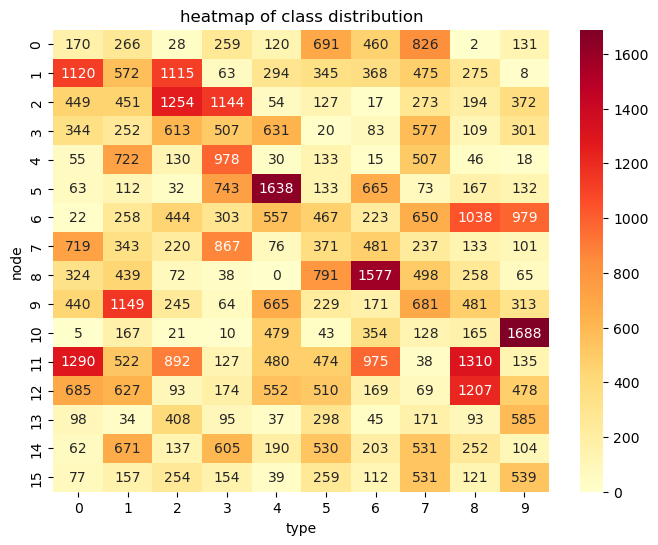

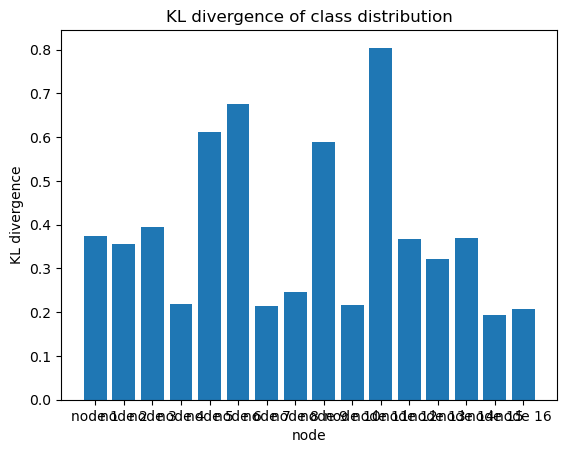

In [8]:
visualize_heatmap(trainloader_list)
visualize_kl_divergence(trainloader_list)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch # Only needed for type hint, not execution within function if loaders passed in
from typing import List

# Helper function to extract class counts from a list of dataloaders
def _get_class_counts(loader_list: List[torch.utils.data.DataLoader], num_classes: int) -> np.ndarray:
    """
    Calculates the number of samples per class for each node's dataloader.

    Args:
        loader_list (List[torch.utils.data.DataLoader]): List of dataloaders, one per node.
        num_classes (int): The total number of classes in the dataset.

    Returns:
        np.ndarray: A 2D numpy array of shape (num_nodes, num_classes) containing counts.
    """
    num_nodes = len(loader_list)
    if num_nodes == 0:
        return np.zeros((0, num_classes))

    class_counts = np.zeros((num_nodes, num_classes))

    for node_idx, loader in enumerate(loader_list):
        # Check if the dataloader's dataset is empty
        if not hasattr(loader, 'dataset') or len(loader.dataset) == 0:
            # print(f"Warning: Node {node_idx} has an empty dataset.")
            continue # Leave counts as zeros for this node

        # Check if the dataset has samples after filtering/subsetting
        # This check might be redundant if the outer check works, but can be useful
        try:
           if len(loader) == 0 and len(loader.dataset) > 0 :
               # This can happen if batch_size > len(dataset) and drop_last=True
               # Or if the dataset was completely empty initially.
               # We iterate through the dataset directly if loader is empty but dataset isn't
               # Note: This is less efficient than iterating through batches.
               # print(f"Warning: Node {node_idx} loader is empty but dataset has {len(loader.dataset)} samples. Iterating manually.")
               targets = []
               if hasattr(loader.dataset, 'targets'): # For datasets like MNIST, CIFAR
                  targets = np.array(loader.dataset.targets)[loader.dataset.indices]
               elif hasattr(loader.dataset, 'labels'): # For datasets loaded differently
                  targets = np.array(loader.dataset.labels)[loader.dataset.indices]
               elif isinstance(loader.dataset, torch.utils.data.Subset):
                    # Handle subset wrapping potentially multiple times or ConcatDataset
                    subset_indices = loader.dataset.indices
                    original_dataset = loader.dataset.dataset
                    if isinstance(original_dataset, torch.utils.data.ConcatDataset):
                        original_labels = np.concatenate([np.array(d.targets) for d in original_dataset.datasets])
                    elif hasattr(original_dataset, 'targets'):
                        original_labels = np.array(original_dataset.targets)
                    elif hasattr(original_dataset, 'labels'):
                         original_labels = np.array(original_dataset.labels)
                    else:
                        print(f"Error: Cannot extract labels from dataset type {type(original_dataset)} for node {node_idx}")
                        original_labels = None

                    if original_labels is not None:
                       targets = original_labels[subset_indices]

               if len(targets) > 0:
                   unique_labels, counts = np.unique(targets, return_counts=True)
                   for cls, count in zip(unique_labels, counts):
                       if 0 <= cls < num_classes:
                           class_counts[node_idx, cls] += count
               continue # Skip the batch iteration for this loader

        except Exception as e:
            print(f"Error processing node {node_idx} dataset/loader: {e}")
            continue


        # --- Original batch iteration method ---
        processed_samples = 0
        for _, labels in loader:
            for cls in range(num_classes):
                class_counts[node_idx, cls] += (labels == cls).sum().item()
            processed_samples += len(labels)

        # Verification check (optional): Compare total count with dataset size
        # total_counted = class_counts[node_idx, :].sum()
        # if total_counted != len(loader.dataset):
        #     print(f"Node {node_idx}: Count mismatch. Dataset size {len(loader.dataset)}, counted {total_counted}")


    return class_counts

# New function to plot combined heatmaps using subplots
def visualize_combined_heatmap_subplots(
    loader_list1: List[torch.utils.data.DataLoader],
    loader_list2: List[torch.utils.data.DataLoader],
    num_classes: int,
    title1: str = "Distribution 1 (e.g., Uniform)",
    title2: str = "Distribution 2 (e.g., Heterogeneous)",
    main_title: str = "Comparison of Class Distributions per Node",
    figsize: tuple = (10, 12),
    cmap: str = 'YlOrRd'
):
    """
    Visualizes class distribution heatmaps for two sets of dataloaders side-by-side.

    Args:
        loader_list1 (List[torch.utils.data.DataLoader]): First list of dataloaders (e.g., uniform).
        loader_list2 (List[torch.utils.data.DataLoader]): Second list of dataloaders (e.g., heterogeneous).
        num_classes (int): The total number of classes.
        title1 (str): Title for the first heatmap.
        title2 (str): Title for the second heatmap.
        main_title (str): Overall title for the figure.
        figsize (tuple): Figure size.
        cmap (str): Colormap for the heatmaps.
    """
    print("Calculating class counts for Distribution 1...")
    class_counts1 = _get_class_counts(loader_list1, num_classes)
    print("Calculating class counts for Distribution 2...")
    class_counts2 = _get_class_counts(loader_list2, num_classes)

    num_nodes1 = class_counts1.shape[0]
    num_nodes2 = class_counts2.shape[0]

    if num_nodes1 == 0 and num_nodes2 == 0:
        print("Both dataloader lists are empty. Nothing to plot.")
        return
    elif num_nodes1 == 0:
        print("Warning: First dataloader list is empty. Plotting only the second.")
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        sns.heatmap(class_counts2, annot=True, fmt='.0f', cmap=cmap, ax=ax)
        ax.set_title(title2)
        ax.set_xlabel('Class Index')
        ax.set_ylabel('Node Index')
        fig.suptitle(main_title)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        return
    elif num_nodes2 == 0:
        print("Warning: Second dataloader list is empty. Plotting only the first.")
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        sns.heatmap(class_counts1, annot=True, fmt='.0f', cmap=cmap, ax=ax)
        ax.set_title(title1)
        ax.set_xlabel('Class Index')
        ax.set_ylabel('Node Index')
        fig.suptitle(main_title)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
        return


    # Determine global min/max for consistent color scaling across plots
    vmin = 0
    vmax = max(np.max(class_counts1) if class_counts1.size > 0 else 0,
               np.max(class_counts2) if class_counts2.size > 0 else 0)

    # Create subplots (one above the other)
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

    # Plot heatmap for the first list
    sns.heatmap(class_counts1, annot=True, fmt='.0f', cmap=cmap, ax=axes[0], vmin=vmin, vmax=vmax)
    axes[0].set_title(title1)
    axes[0].set_ylabel('Node Index')
    # axes[0].set_xlabel('Class Index') # Keep x-label only on the bottom plot due to sharex

    # Plot heatmap for the second list
    sns.heatmap(class_counts2, annot=True, fmt='.0f', cmap=cmap, ax=axes[1], vmin=vmin, vmax=vmax)
    axes[1].set_title(title2)
    axes[1].set_ylabel('Node Index')
    axes[1].set_xlabel('Class Index')

    # Add main title
    fig.suptitle(main_title, fontsize=16, y=0.98) # Adjust y to prevent overlap

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect to make space for suptitle

    plt.show()

In [5]:
n = 16
dataset_name = "MNIST"
batch_size = 128
repeat = 1

trainloader_list_uniform, testloader_uniform, full_trainloader_uniform = get_dataloaders(n, dataset_name, batch_size, repeat)
trainloader_list_hetero, testloader_hetero, full_trainloader_hetero = get_dataloaders_hetero_balanced(n, dataset_name, batch_size, repeat)

Calculating class counts for Distribution 1...
Calculating class counts for Distribution 2...


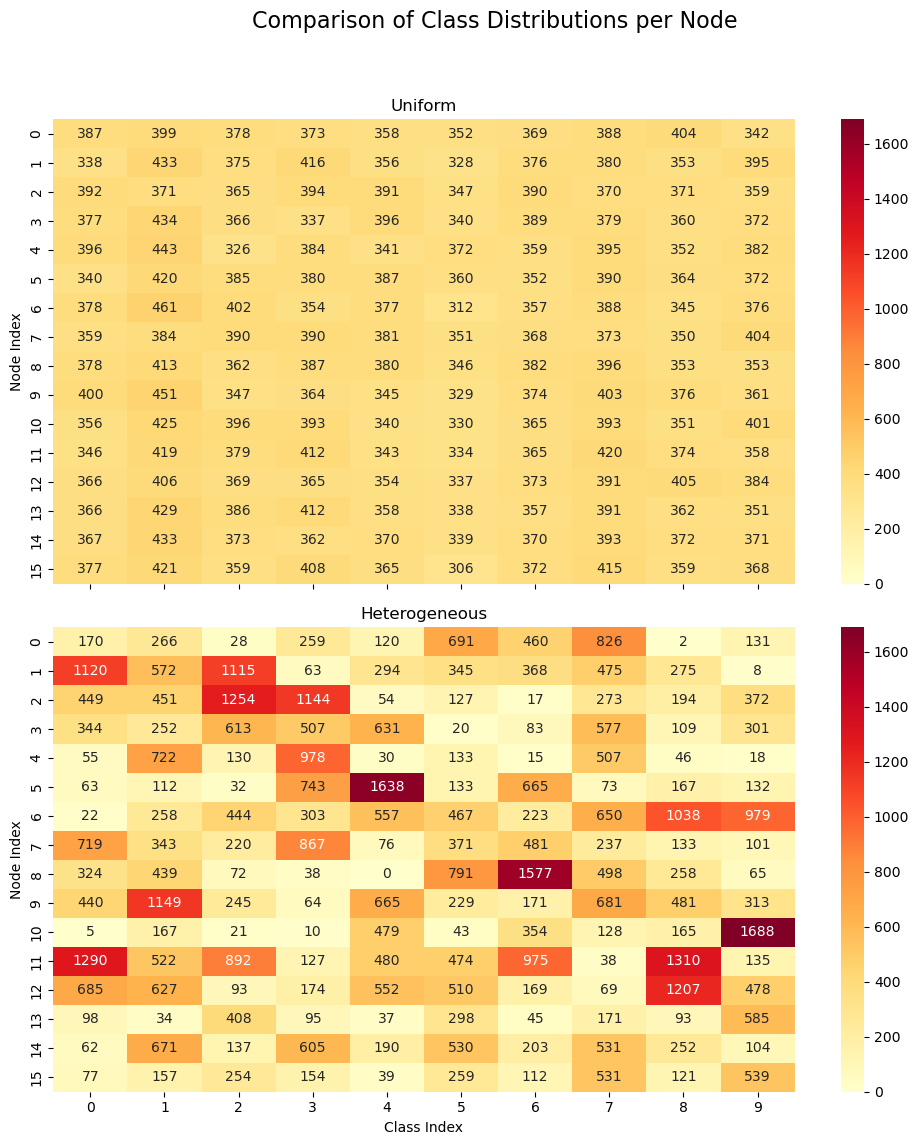

In [6]:
visualize_combined_heatmap_subplots(
    loader_list1 = trainloader_list_uniform,
    loader_list2 = trainloader_list_hetero,
    num_classes = 10,
    title1 = "Uniform",
    title2 = "Heterogeneous",
    main_title = "Comparison of Class Distributions per Node",
    figsize = (10, 12),
    cmap = 'YlOrRd'
)

In [8]:
n = 16
dataset_name = "MNIST"
batch_size = 128
repeat = 1

trainloader_list_uniform, testloader_uniform, full_trainloader_uniform = get_dataloaders(n, dataset_name, batch_size, repeat)
trainloader_list_hetero, testloader_hetero, full_trainloader_hetero = get_dataloaders_hetero_balanced(n, dataset_name, batch_size, repeat)

loader_list1 = trainloader_list_uniform
loader_list2 = trainloader_list_hetero
num_classes = 10
title1 = "Uniform"
title2 = "Heterogeneous"
main_title = "Comparison of Class Distributions per Node"
figsize = (10, 12)
cmap = 'YlOrRd'

In [9]:
print("Calculating class counts for Distribution 1...")
class_counts1 = _get_class_counts(loader_list1, num_classes)
print("Calculating class counts for Distribution 2...")
class_counts2 = _get_class_counts(loader_list2, num_classes)

Calculating class counts for Distribution 1...
Calculating class counts for Distribution 2...


In [10]:
num_nodes1 = class_counts1.shape[0]
num_nodes2 = class_counts2.shape[0]

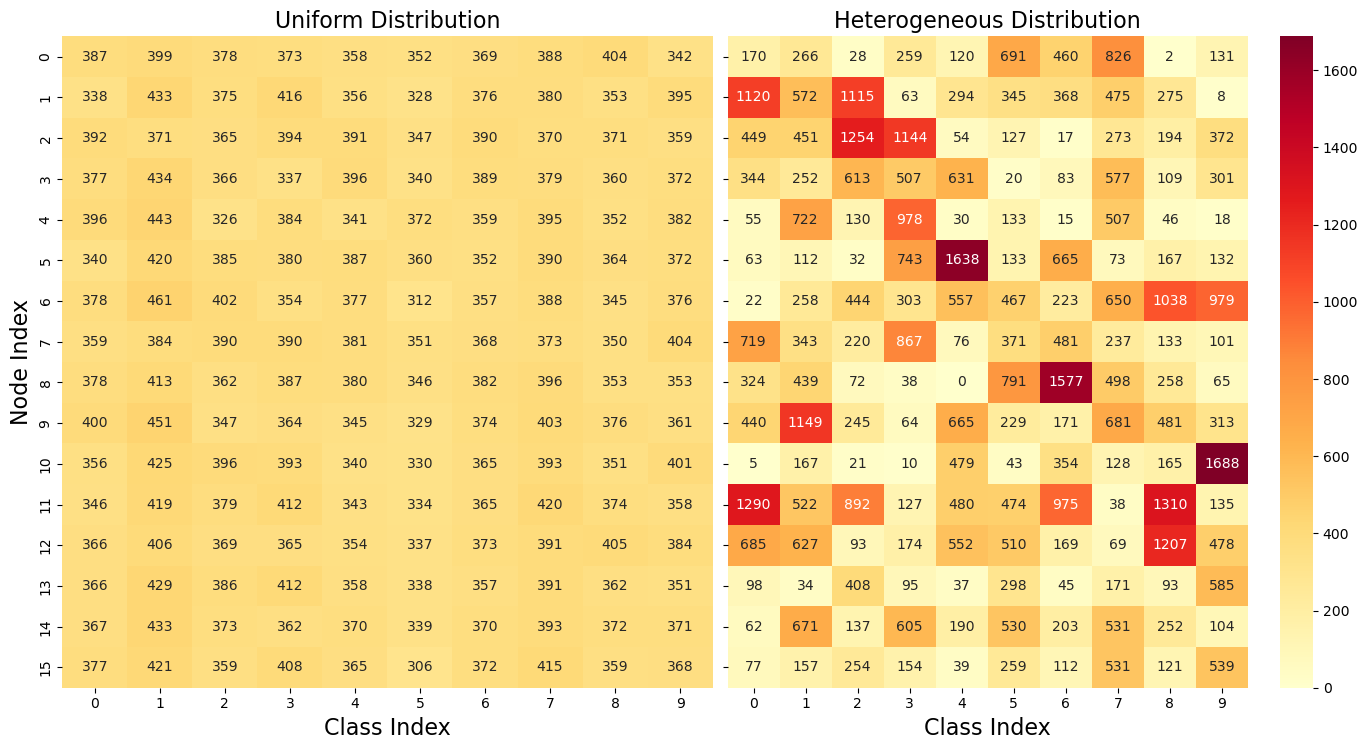

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Determine the global min and max counts for consistent color scaling
vmin = 0 # Assuming counts cannot be negative
vmax = max(np.max(class_counts1) if class_counts1.size > 0 else 0,
           np.max(class_counts2) if class_counts2.size > 0 else 0)

# 2. Create the figure and axes (1 row, 2 columns)
# Adjust figsize as needed
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True) # sharey=True aligns nodes vertically

# 3. Plot the first heatmap (left subplot) - NO color bar
sns.heatmap(class_counts1,
            annot=True,       # Show numbers in cells
            fmt='.0f',        # Format numbers as integers
            cmap='YlOrRd',    # Colormap (choose one you like)
            ax=axes[0],       # Target the left axis
            vmin=vmin,        # Set min color scale
            vmax=vmax,        # Set max color scale
            cbar=False)       # IMPORTANT: Disable color bar for this plot
axes[0].set_title('Uniform Distribution', fontsize = 16)
axes[0].set_ylabel('Node Index',fontsize = 16)
axes[0].set_xlabel('Class Index',fontsize = 16)

# 4. Plot the second heatmap (right subplot) - WITH color bar
sns.heatmap(class_counts2,
            annot=True,
            fmt='.0f',
            cmap='YlOrRd',
            ax=axes[1],
            vmin=vmin,
            vmax=vmax,
            cbar=True,        # IMPORTANT: Enable color bar for this plot
            #cbar_kws={'label': 'Number of Samples'}
            ) # Add label to the color bar
axes[1].set_title('Heterogeneous Distribution', fontsize = 16)
# axes[1].set_ylabel('') # Remove y-label if using sharey=True (already on the left)
axes[1].set_xlabel('Class Index',fontsize = 16)
# axes[1].set_yticks([]) # Alternative way to hide y-ticks if not using sharey

# 5. Add an overall title (optional)
#fig.suptitle('Comparison of Class Distributions per Node', fontsize=16)

# 6. Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect to make space for suptitle
plt.savefig("heatmap.pdf")
# 7. Show the plot
plt.show()


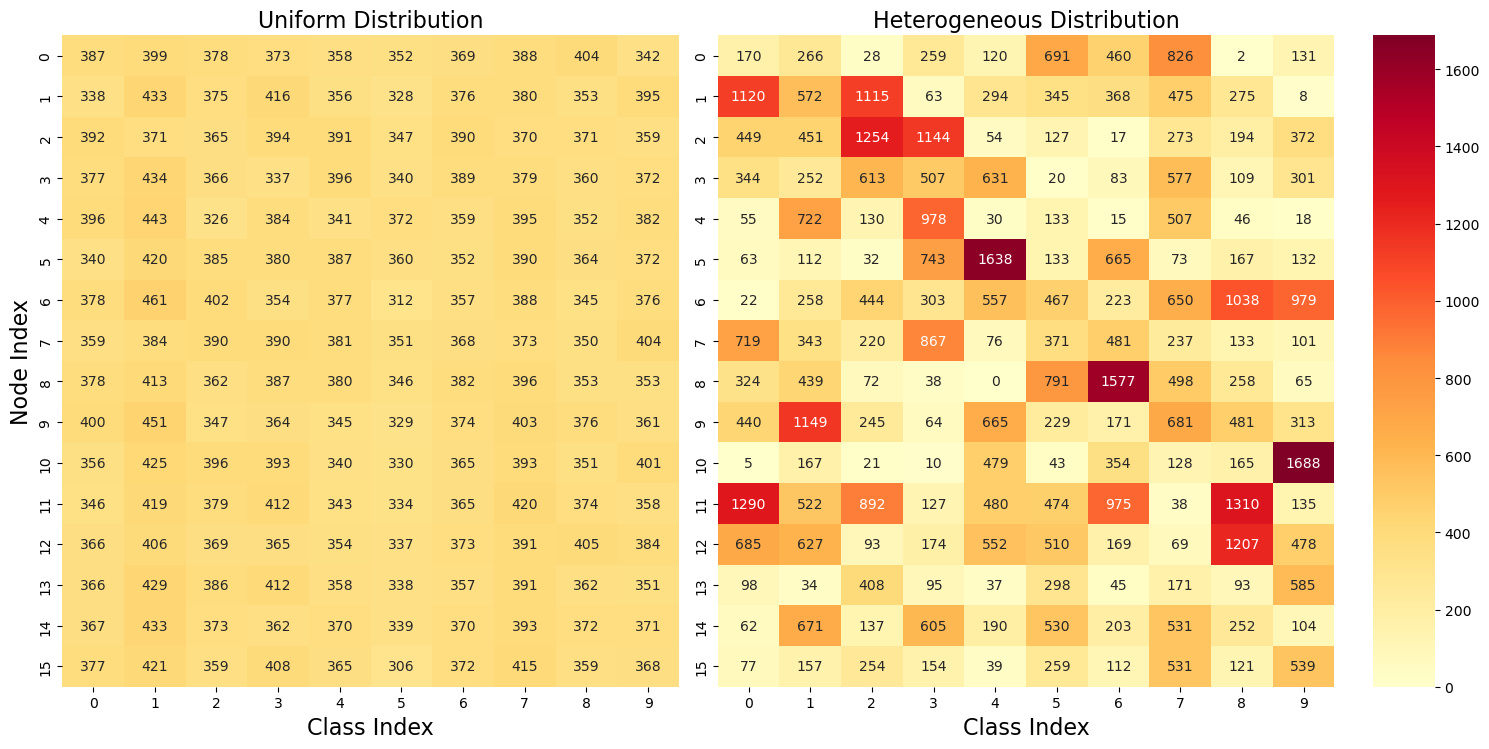

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

# 1. Determine the global min and max counts for consistent color scaling
vmin = 0 # Assuming counts cannot be negative
vmax = max(np.max(class_counts1) if class_counts1.size > 0 else 0,
           np.max(class_counts2) if class_counts2.size > 0 else 0)

# 2. Create figure and gridspec layout
fig = plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.1])  # 两个热图宽度相等，第3列为颜色条

# 3. Create axes for heatmaps and colorbar
ax1 = plt.subplot(gs[0])  # 左图
ax2 = plt.subplot(gs[1], sharey=ax1)  # 右图，与左图共享y轴
cbar_ax = plt.subplot(gs[2])  # 颜色条专用轴

# 4. Plot the first heatmap (left subplot) - NO color bar
sns.heatmap(class_counts1,
            annot=True,       # Show numbers in cells
            fmt='.0f',        # Format numbers as integers
            cmap='YlOrRd',    # Colormap (choose one you like)
            ax=ax1,           # Target the left axis
            vmin=vmin,        # Set min color scale
            vmax=vmax,        # Set max color scale
            cbar=False)       # IMPORTANT: Disable color bar for this plot
ax1.set_title('Uniform Distribution', fontsize=16)
ax1.set_ylabel('Node Index', fontsize=16)
ax1.set_xlabel('Class Index', fontsize=16)

# 5. Plot the second heatmap (right subplot) - WITH color bar
sns.heatmap(class_counts2,
            annot=True,
            fmt='.0f',
            cmap='YlOrRd',
            ax=ax2,
            vmin=vmin,
            vmax=vmax,
            cbar=True,
            cbar_ax=cbar_ax,  # 指定颜色条绘制在独立的轴上
            #cbar_kws={'label': 'Number of Samples'}
            )  # 添加颜色条标签
ax2.set_title('Heterogeneous Distribution', fontsize=16)
ax2.set_xlabel('Class Index', fontsize=16)

# 6. Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make space for suptitle

# 7. Save the plot to PDF (在 plt.show() 之前)
plt.savefig("heatmap_new.pdf", format='pdf', bbox_inches='tight')

# 8. Show the plot
plt.show()

In [19]:
n = 16
dataset_name = "MNIST"
batch_size = 128
repeat = 1

trainloader_list_hetero, testloader_hetero, full_trainloader_hetero = get_dataloaders_hetero_balanced(n, dataset_name, batch_size, repeat)

/tmp/ipykernel_4092175/3326882472.py:127: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  labels = np.array(trainset.targets)


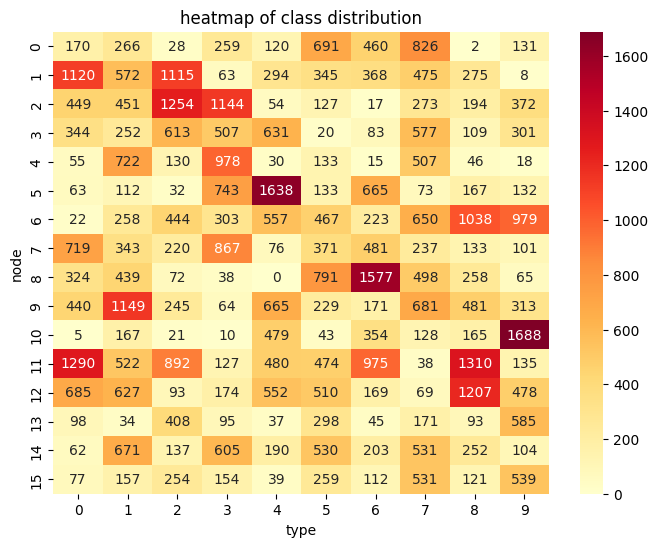

In [20]:
visualize_heatmap(trainloader_list_hetero)